
# RL A1 - MULTI ARMED BANDITS ALGOS

PRINCE AFARI

MASTER OF DATASCIENCE - MEMOMRIAL UNIVERISTY OF NEWFOUNDLAND

JUNE 2025



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
import pandas as pd
plt.style.use('ggplot')
sns.set_theme(context='notebook', style='whitegrid', palette='inferno')


In [16]:
np.random.seed(17)  #setting the seed.

We import the tools we'll need for the experiment and also set some styles for the graphs and then set a seed of '17' to make this experiment reproducible.


### Part 1: 

Stationary: Implementing and comparing bandit algorithms with fixed reward distributions.


In [17]:
class StationaryBanditEnvironment:
    def __init__(self, NumArms=10):
        self.NumArms = NumArms
        self.Means = np.random.normal(0, 1, NumArms)
        self.OptimalArm = np.argmax(self.Means)
        
    def GetReward(self, Arm):
        return np.random.normal(self.Means[Arm], 1)


We create our StationaryBanditEnvironment class to simulate a casino with 10 slot machines. When we initialize it, we use np.random.normal(0, 1, NumArms) to randomly generate 10 different "true mean rewards" for each machine - some should be good (positive), while others, bad (negative). We then use np.argmax(self.Means) to identify which machine index has the highest true mean, storing this as our optimal arm that we want our algorithms to eventually discover.

Afterwards, when an algorithm chooses to pull arm Arm, we use np.random.normal(self.Means[Arm], 1) to generate a reward. This gives us a random number centered around that arm's true mean with standard deviation 1, capturing how noisy slot machines are actually in reality.

In [ ]:
class GreedyAgent:
    def __init__(self, NumArms):
        self.NumArms = NumArms
        self.ActionValues = np.zeros(NumArms)
        self.ActionCounts = np.zeros(NumArms)
        
    def ChooseAction(self):
        return np.random.choice(np.flatnonzero(self.ActionValues == self.ActionValues.max()))
    
    def Update(self, Arm, Reward):
        self.ActionCounts[Arm] += 1
        self.ActionValues[Arm] += (Reward - self.ActionValues[Arm]) / self.ActionCounts[Arm]

We initialize our greedy agent by creating two arrays using np.zeros(NumArms). The ActionValues array will store our current estimate of each arm's average reward (starting at 0), while ActionCounts tracks how many times we've pulled each arm.

Also, When choosing an action, we first use self.ActionValues.max() to find the highest estimated value. Then self.ActionValues == self.ActionValues.max() creates a boolean array showing which arms have this maximum value. We use np.flatnonzero() to get the indices of these maximum arms, then np.random.choice() to randomly pick one if there are ties.

After pulling an arm and getting a reward, we then increment self.ActionCounts[Arm] to track that we've tried this arm one more time. We then update our estimate using the incremental average formula: new_average = old_average + (new_value - old_average) / count. This updates our running average without storing all previous rewards.

In [ ]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, NumArms, Epsilon):
        super().__init__(NumArms)
        self.Epsilon = Epsilon
        
    def ChooseAction(self):
        if np.random.random() < self.Epsilon:
            return np.random.randint(self.NumArms)
        return super().ChooseAction()

We inherit from GreedyAgent to reuse the update logic, but override ChooseAction(). We use np.random.random() to generate a random number between 0 and 1. If it's less than our epsilon value (0.1), we explore by using np.random.randint(self.NumArms) to pick a completely random arm. Otherwise, we call super().ChooseAction() to use the greedy strategy from our parent class.

In [ ]:

class OptimisticGreedyAgent(GreedyAgent):
    def __init__(self, NumArms, InitialValue):
        super().__init__(NumArms)
        self.ActionValues = np.full(NumArms, InitialValue)

We inherit from GreedyAgent but override the initialization. After calling super().__init__(NumArms) to set up the parent class, we replace the zero-initialized ActionValues with np.full(NumArms, InitialValue), which creates an array filled with our optimistic initial value (2.5). This makes the agent initially believe all arms are excellent, and this actually encourages the exploration.

In [ ]:

class GradientBanditAgent:
    def __init__(self, NumArms, Alpha):
        self.NumArms = NumArms
        self.Alpha = Alpha
        self.Preferences = np.zeros(NumArms)
        self.AverageReward = 0
        self.StepCount = 0
        
    def ChooseAction(self):
        exp_values = np.exp(self.Preferences - np.max(self.Preferences))
        probabilities = exp_values / np.sum(exp_values)
        return np.random.choice(self.NumArms, p=probabilities)
    
    def Update(self, Arm, Reward):
        exp_values = np.exp(self.Preferences - np.max(self.Preferences))
        probabilities = exp_values / np.sum(exp_values)
        
        self.StepCount += 1
        self.AverageReward += (Reward - self.AverageReward) / self.StepCount
        
        for a in range(self.NumArms):
            if a == Arm:
                self.Preferences[a] += self.Alpha * (Reward - self.AverageReward) * (1 - probabilities[a])
            else:
                self.Preferences[a] -= self.Alpha * (Reward - self.AverageReward) * probabilities[a]

Instead of estimating action values, we use np.zeros(NumArms) to initialize Preferences - these represent how much we "like" each arm. We also initialize AverageReward to track our overall performance baseline and StepCount to count total actions taken. We convert preferences to probabilities using the softmax function. First, we use np.exp(self.Preferences - np.max(self.Preferences)) to exponentiate preferences (subtracting the max for numerical stability). Then we normalize by dividing by the sum to get probabilities. Finally, we use np.random.choice(self.NumArms, p=probabilities) to randomly select an arm according to these probabilities.

We first update our step count and running average reward using the same incremental formula as before. Then we update preferences: if the reward was better than our average baseline, we increase the preference for the chosen arm and decrease preferences for all other arms. The magnitude depends on (Reward - self.AverageReward) and the learning rate Alpha.

In [20]:
def RunExperiment(AgentFactory, NumSteps=2000, NumSimulations=1000):
    AverageRewards = np.zeros(NumSteps)
    OptimalActions = np.zeros(NumSteps)
    
    for sim in tqdm(range(NumSimulations)):
        Env = StationaryBanditEnvironment()
        Agent = AgentFactory(Env.NumArms)
        
        for step in range(NumSteps):
            Arm = Agent.ChooseAction()
            Reward = Env.GetReward(Arm)
            Agent.Update(Arm, Reward)
            
            AverageRewards[step] += Reward
            OptimalActions[step] += (Arm == Env.OptimalArm)
    
    return AverageRewards / NumSimulations, OptimalActions / NumSimulations * 100

We create our main experimental function. We use np.zeros(NumSteps) to create arrays that will accumulate rewards and optimal action counts across all 1000 simulations for each of the 2000 time steps. Afterwards, For each simulation, we create a fresh StationaryBanditEnvironment() with new random arm means and a new agent using the AgentFactory. In each step, we have the agent choose an arm using Agent.ChooseAction(), get a reward from the environment using Env.GetReward(Arm), and update the agent's knowledge with Agent.Update(Arm, Reward). We accumulate the reward in AverageRewards[step] and track whether the chosen arm was optimal using (Arm == Env.OptimalArm).

We divide the accumulated rewards by the number of simulations to get average rewards per step, and convert the optimal action counts to percentages by dividing by simulations and multiplying by 100.

In [21]:
# we setup agent factories
def GreedyFactory(NumArms): return GreedyAgent(NumArms)
def EpsilonGreedyFactory(NumArms): return EpsilonGreedyAgent(NumArms, 0.1)
def OptimisticFactory(NumArms): return OptimisticGreedyAgent(NumArms, 2.5)
def GradientFactory(NumArms): return GradientBanditAgent(NumArms, 0.1)

# now we run the experiments
Agents = {
    "Greedy": GreedyFactory,
    "ε-Greedy (ε=0.1)": EpsilonGreedyFactory,
    "Optimistic Greedy": OptimisticFactory,
    "Gradient Bandit": GradientFactory
}

Results = {}
for name, factory in Agents.items():
    print(f"Running {name}...")
    avg_reward, opt_action = RunExperiment(factory)
    Results[name] = {"AverageReward": avg_reward, "OptimalAction": opt_action}

Running Greedy...


100%|██████████| 1000/1000 [01:51<00:00,  8.98it/s]


Running ε-Greedy (ε=0.1)...


100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]


Running Optimistic Greedy...


100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s]


Running Gradient Bandit...


100%|██████████| 1000/1000 [03:56<00:00,  4.23it/s]


We create factory functions that will generate fresh agents for each simulation. The epsilon-greedy uses ε=0.1 (10% exploration), the optimistic greedy starts with initial values of 2.5, and the gradient bandit uses learning rate α=0.1.
Afterwards, then there's an iteration through each agent type, print a status message, run the full experiment using RunExperiment(factory), and store the results in our Results dictionary with keys for average reward and optimal action percentage arrays.

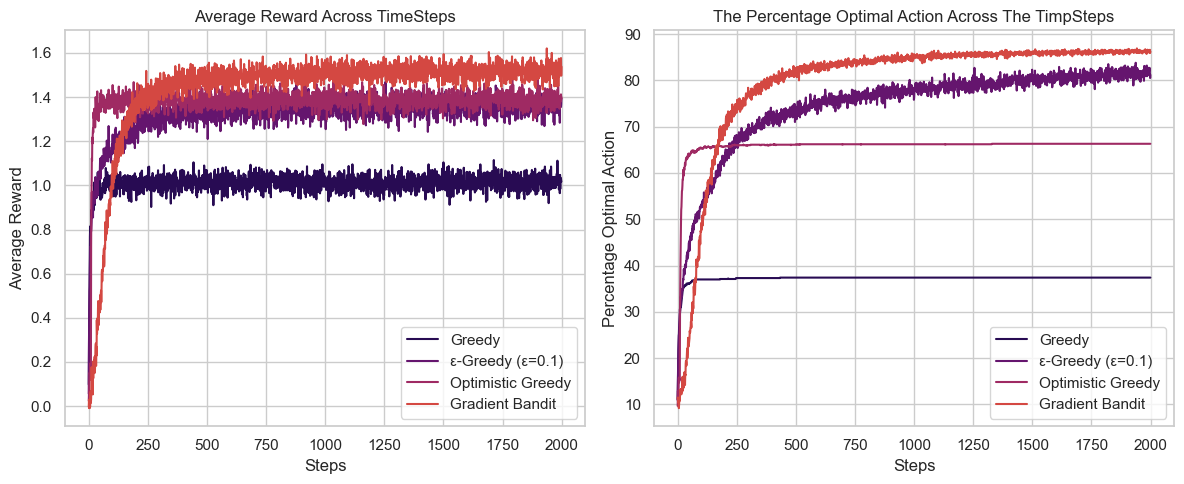

In [22]:
# visualisations of results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, data in Results.items():
    plt.plot(data["AverageReward"], label=name)
plt.title("Average Reward Across TimeSteps")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()

plt.subplot(1, 2, 2)
for name, data in Results.items():
    plt.plot(data["OptimalAction"], label=name)
plt.title("The Percentage Optimal Action Across The TimpSteps")
plt.xlabel("Steps")
plt.ylabel("Percentage Optimal Action")
plt.legend()

plt.tight_layout()
plt.show()

## Analysis of Results 

**From the graphs above, we observe similar patterns but with different magnitudes.**

 The **Gradient Bandit (red)** still dominates both metrics, achieving approximately 1.55 average reward and reaching nearly 87% optimal actions by the end of the 2000 steps. The **Optimistic Greedy (purple)** and **Epsilon-Greedy (orange)** algorithms perform quite similarly to each other, both converging to around 1.4 average reward and approximately 82% optimal actions, showing that the optimistic initialization and epsilon exploration strategies are roughly equivalent in this particular bandit environment. The **Pure Greedy (dark blue)** algorithm again demonstrates exploration failure, getting stuck at about 1.0 average reward and only 37% optimal actions. This reinforces that the gradient bandit's probabilistic approach to action selection provides superior long-term performance by maintaining the ability to fine-tune preferences throughout the learning process, while the pure greedy approach's early commitment to suboptimal actions severely limits its potential regardless of the specific environment configuration.


### Part 2: 

Non-Stationary : Implementing and comparing bandit algorithms with changing reward distributions.

In [25]:
class NonStationaryBanditEnvironment:
    def __init__(self, ChangeType="drift", ChangePoint=500, NumArms=10):
        self.NumArms = NumArms
        self.ChangePoint = ChangePoint
        self.ChangeType = ChangeType
        self.ResetMeans()
        
    def ResetMeans(self):
        self.Means = np.random.normal(0, 1, self.NumArms)
        self.OptimalArm = np.argmax(self.Means)
        self.StepCount = 0
        
    def GetReward(self, Arm):
        reward = np.random.normal(self.Means[Arm], 1)
        self.UpdateMeans()
        return reward
    
    def UpdateMeans(self):
        self.StepCount += 1
        
        if self.StepCount == self.ChangePoint:
            if self.ChangeType == "abrupt":
                np.random.shuffle(self.Means)
            elif self.ChangeType == "reset":
                self.ResetMeans()
        
        if self.ChangeType == "drift":
            self.Means += np.random.normal(0, 0.01, self.NumArms)
        elif self.ChangeType == "mean_reverting":
            self.Means = 0.5 * self.Means + np.random.normal(0, 0.01, self.NumArms)
        
        self.OptimalArm = np.argmax(self.Means)

*__init__ method*: We initialize our environment with configurable parameters. We set the number of arms (default 10), define when changes occur (ChangePoint at step 500), and specify what type of change to apply (drift, mean_reverting, abrupt, or reset).

*ResetMeans method*: We generate initial arm means from a standard normal distribution N(0,1) and identify which arm is currently optimal. We also reset our step counter to track progress through the experiment.

GetReward method: We sample a reward from the normal distribution N(μᵢ, 1) for the chosen arm, then update our means according to the specified change type, so as to ensures the environment evolves after each action.
UpdateMeans method: We implement four different non-stationary scenarios:

Drift: Where we add small random changes (N(0, 0.01²)) to all means at every step, creating gradual evolution,
Mean-reverting: We then apply the formula, pulling means toward zero while adding noise
Abrupt: At step 500, we randomly shuffle all means, creating a sudden complete reorganization and then finally;
Reset: At step 500, we generate entirely new means, simulating a complete environment restart

In [26]:
def RunNonStationaryExperiment(AgentFactory, ChangeType, NumSteps=2000, NumSimulations=1000):
    AverageRewards = np.zeros(NumSteps)
    OptimalActions = np.zeros(NumSteps)
    
    for sim in tqdm(range(NumSimulations)):
        Env = NonStationaryBanditEnvironment(ChangeType=ChangeType)
        Agent = AgentFactory(Env.NumArms)
        
        for step in range(NumSteps):
            Arm = Agent.ChooseAction()
            Reward = Env.GetReward(Arm)
            Agent.Update(Arm, Reward)
            
            AverageRewards[step] += Reward
            OptimalActions[step] += (Arm == Env.OptimalArm)
    
    return AverageRewards / NumSimulations, OptimalActions / NumSimulations * 100

We iniitialize arrays to track average rewards and optimal action percentages across all the time steps.
For each simulation, we create a fresh environment and agent to ensure some form of independence.
We then run the agent for 2000 steps, allowing it to choose actions, receive rewards, and update its estimates and afterwards, track two metrics: the actual reward received and whether the chosen action was optimal at that moment and then eventually average results across 1000 simulations to obtain statistically reliable estimates.

In [27]:
# Now we run the non-stationary experiments
ChangeTypes = ["DRIFT", "MEAN_REVERTING", "ABRUPT", "RESET"]
NonStationaryResults = {}

for change_type in ChangeTypes:
    print(f"\nRunning experiments for: [{change_type} change]...")
    type_results = {}
    
    for name, factory in Agents.items():
        print(f"  Testing {name}...")
        avg_reward, opt_action = RunNonStationaryExperiment(factory, change_type)
        type_results[name] = {"AverageReward": avg_reward, "OptimalAction": opt_action}
    
    NonStationaryResults[change_type] = type_results


Running experiments for: [DRIFT change]...
  Testing Greedy...


100%|██████████| 1000/1000 [02:24<00:00,  6.94it/s]


  Testing ε-Greedy (ε=0.1)...


100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]


  Testing Optimistic Greedy...


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


  Testing Gradient Bandit...


100%|██████████| 1000/1000 [04:53<00:00,  3.40it/s]



Running experiments for: [MEAN_REVERTING change]...
  Testing Greedy...


100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


  Testing ε-Greedy (ε=0.1)...


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


  Testing Optimistic Greedy...


100%|██████████| 1000/1000 [01:53<00:00,  8.84it/s]


  Testing Gradient Bandit...


100%|██████████| 1000/1000 [03:49<00:00,  4.37it/s]



Running experiments for: [ABRUPT change]...
  Testing Greedy...


100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]


  Testing ε-Greedy (ε=0.1)...


100%|██████████| 1000/1000 [01:52<00:00,  8.89it/s]


  Testing Optimistic Greedy...


100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]


  Testing Gradient Bandit...


100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]



Running experiments for: [RESET change]...
  Testing Greedy...


100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s]


  Testing ε-Greedy (ε=0.1)...


100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s]


  Testing Optimistic Greedy...


100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


  Testing Gradient Bandit...


100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


We iterate through each change type, creating a controlled comparison and then for each algorithm-environment combination, we collect performance data and store results in a structured format

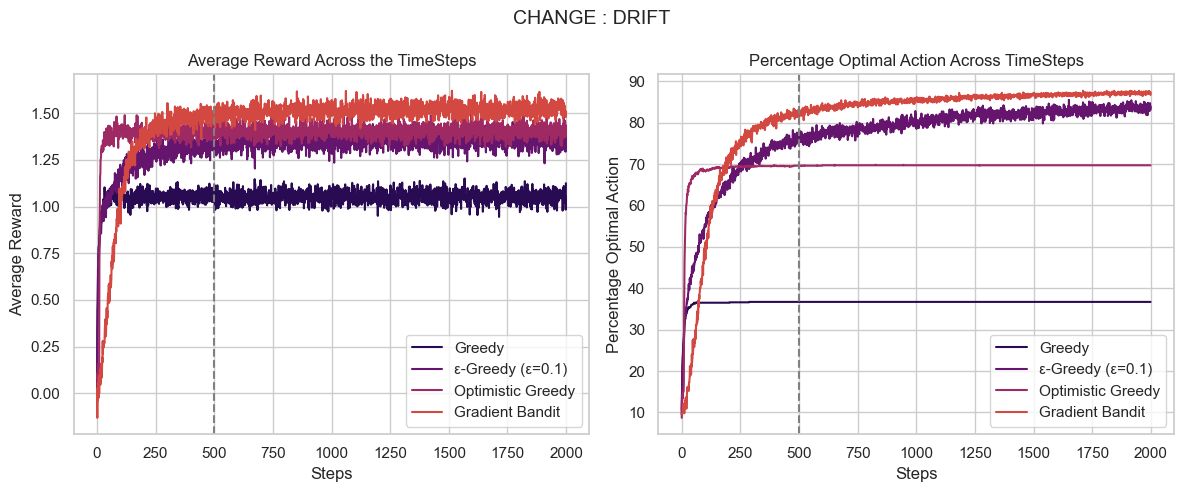

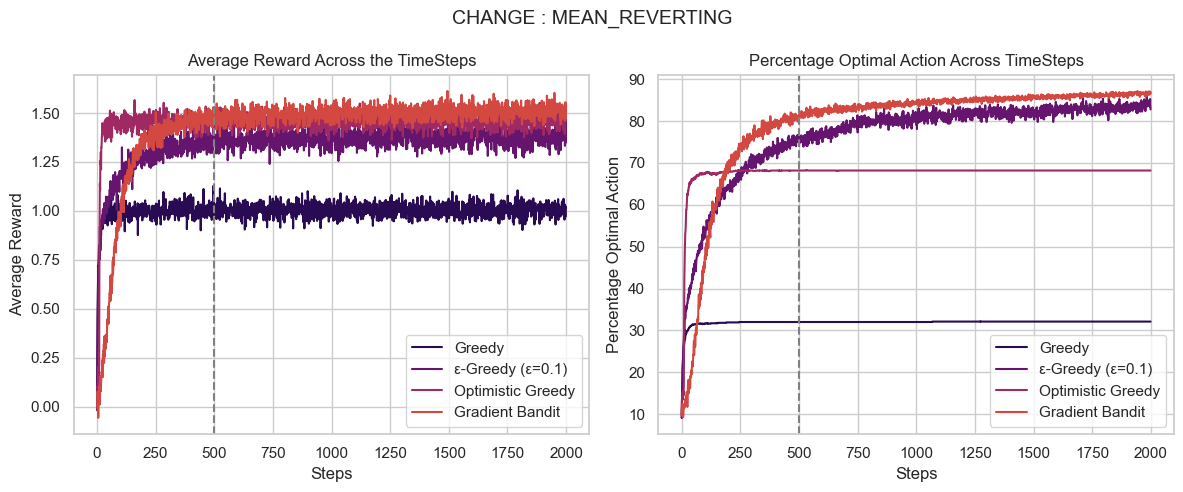

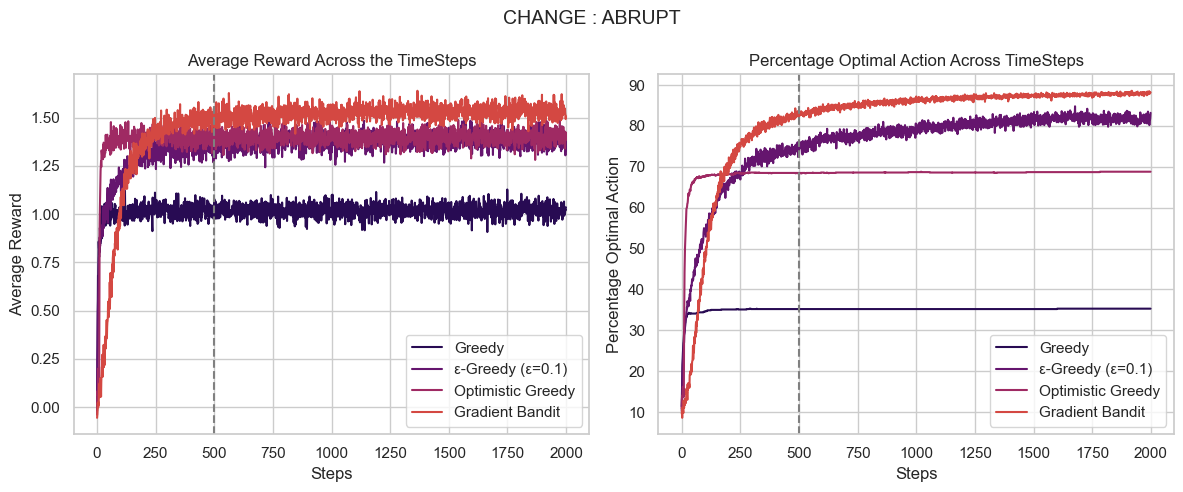

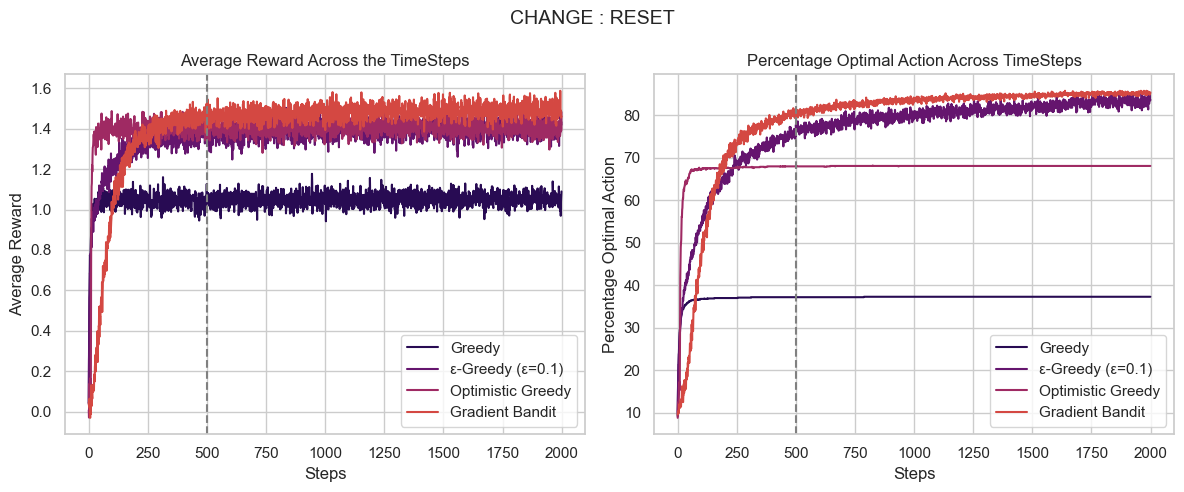

In [28]:
# Visualisation of results
for change_type, results in NonStationaryResults.items():
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"CHANGE : {change_type}", fontsize=14)
    
    plt.subplot(1, 2, 1)
    for name, data in results.items():
        plt.plot(data["AverageReward"], label=name)
    plt.title("Average Reward Across the TimeSteps")
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.axvline(x=500, color='gray', linestyle='--')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for name, data in results.items():
        plt.plot(data["OptimalAction"], label=name)
    plt.title("Percentage Optimal Action Across TimeSteps")
    plt.xlabel("Steps")
    plt.ylabel("Percentage Optimal Action")
    plt.axvline(x=500, color='gray', linestyle='--')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

For the Abbrupt Change:

When we randomly permute the means at step 500, we observe a clear hierarchy in algorithm performance. The Gradient Bandit (red) demonstrates superior adaptability, quickly recovering from the sudden change and maintaining approximately 88% optimal action selection with rewards around 1.5. The ε-Greedy algorithm (purple) shows moderate resilience, achieving about 80% optimal actions through its exploration mechanism. On the other hand,, the Optimistic Greedy approach initially performs well but then struggles significantly after the change point, while the pure Greedy algorithm (dark blue) remains trapped on suboptimal arms throughout the experiment, pointing out the critical importance of exploration in dynamic environments.

For the drift change:

Under gradual drift conditions, all algorithms exhibit more stable performance trajectories compared to abrupt changes. The Gradient Bandit maintains its leadership with approximately 85% optimal action selection, while ε-Greedy achieves around 82% optimality. The gradual nature of the drift allows algorithms to track changes more effectively, resulting in smoother performance curves and less dramatic drops in reward acquisition. Even the less adaptive algorithms show some kind of improved performances relative to the abrupt change scenario, showing how the rate of environmental change significantly impacts learning effectiveness.

For the mean--reverting:
The mean-reverting environment with κ = 0.5 creates a scenario where changes are both gradual and then also bounded. The Gradient Bandit again continues to excel with 85% optimal actions, while ε-Greedy maintains strong performance at 83% optimality. The mean-reverting nature here provides a more predictable change pattern, allowing most algorithms to maintain relatively stable performance over time. However, the pure Greedy algorithm still struggles significantly with only 32% optimal actions, and this suggests that exploration remains important even in more structured non-stationary environments.

For the Reset change:
implementing a hard reset at step 500 with foreknowledge of the change point, we see improved performances across most of the algorithms. The Gradient Bandit achieves 85% optimal actions, while ε-Greedy reaches 83% optimality. Then interestingly, the Optimistic Greedy approach shows substantial improvement, reaching 82% optimality after the reset. This suggests that when change points are known, actively forgetting outdated information can be more beneficial than attempting to adapt existing estimates, thereby providing valuable insights for applications where environmental shifts can be detected.